## Setup

You need to define your data folder before using this notebook.
Kill this notebook, run `export PYCOX_DATA_DIR=path/to/folder` and launch this notebook again.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
import logging
import numpy as np
import pandas as pd

assert os.getenv("PYCOX_DATA_DIR"), "env variable PYCOX_DATA_DIR must be set"

The script below downloads the data if you don't have it locally (this can take up to 10min!). You will need Kaggle credentials, see: https://github.com/Kaggle/kaggle-api#api-credentials.

Then, it generates the covariates file if it doesn't exist in your data folder.

In [2]:
from pycox.datasets import kkbox_v1

kkbox_v1._path_dir.mkdir(exist_ok=True)

train_file = kkbox_v1._path_dir / "train.csv"
members_file = kkbox_v1._path_dir / "members_v3.csv"
transactions_file = kkbox_v1._path_dir / "transactions.csv"

any_prior_file_missing = (
    not train_file.exists()
    or not members_file.exists()
    or not transactions_file.exists()
)

covariate_file = kkbox_v1._path_dir / "covariates.feather"
is_covariate_file_missing = not covariate_file.exists()

if is_covariate_file_missing:
    # We need to download any missing prior file
    # before producing the final covariate file.
    if any_prior_file_missing:
        kkbox_v1._setup_download_dir()
        kkbox_v1._7z_from_kaggle()
    kkbox_v1._csv_to_feather_with_types()
    kkbox_v1._make_survival_data()
    kkbox_v1._make_survival_covariates()
    kkbox_v1._make_train_test_split()

### Preprocessing

In [3]:
covariates = pd.read_feather(kkbox_v1._path_dir / "covariates.feather")
covariates

,msno,event,n_prev_churns,days_between_subs,duration,days_since_reg_init,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,city,gender,registered_via,age_at_start,strange_age,nan_days_since_reg_init,no_prev_churns
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,1.0,0.0,0.0,5.0,4549.0,7.0,0.0,0.0,0.0,0.0,15,female,9,28.0,0.0,0.0,1.0
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,1.0,0.0,0.0,410.0,1062.0,410.0,1788.0,1788.0,0.0,0.0,6,female,3,21.0,0.0,0.0,1.0
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.0,0.0,0.0,119.0,892.0,30.0,99.0,99.0,1.0,0.0,1,NaN,7,-0.0,1.0,0.0,1.0
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,1.0,0.0,0.0,413.0,1535.0,31.0,149.0,149.0,1.0,0.0,15,male,9,24.0,0.0,0.0,1.0
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.0,0.0,0.0,790.0,121.0,30.0,149.0,149.0,1.0,0.0,1,NaN,7,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646741,zzz9+ZF4+GMyt63oU8xfjo1EkvRqH5OINlES0RUJI6I=,1.0,0.0,0.0,386.0,0.0,30.0,129.0,129.0,1.0,0.0,1,NaN,7,0.0,1.0,0.0,1.0
2646742,zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=,0.0,0.0,0.0,27.0,7.0,30.0,149.0,149.0,1.0,0.0,4,male,3,26.0,0.0,0.0,1.0
2646743,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,1.0,0.0,0.0,335.0,-1.0,30.0,99.0,99.0,1.0,0.0,NaN,NaN,NaN,-1.0,0.0,1.0,1.0
2646744,zzztsqkufVj9DPVJDM3FxDkhlbCL5z4aiYxgPSGkIK4=,1.0,0.0,0.0,7.0,125.0,7.0,0.0,0.0,0.0,0.0,1,female,3,30.0,0.0,0.0,1.0


In [4]:
def extra_cleaning(df):
    # remove id
    df.pop("msno")

    # ordinal encode gender
    df["gender"] = df["gender"].astype(str)
    gender_map = dict(zip(df["gender"].unique(), range(df["gender"].nunique())))
    df["gender"] = df["gender"].map(gender_map)
    
    # remove tricky np.nan in city, encoded as int
    df["city"] = df["city"].astype(str).replace("nan", -1).astype(int)
    
    # same for registered via
    df["registered_via"] = df["registered_via"].astype(str).replace("nan", -1).astype(int)
    
    return df

In [5]:
covariates = extra_cleaning(covariates)
covariates.isna().sum().sum()

0

In [6]:
from sksurv.datasets import get_x_y

X, y = get_x_y(covariates, ("event", "duration"), pos_label=1)

/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


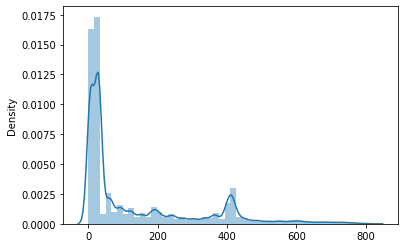

In [7]:
import seaborn as sns

mask = np.where(y["event"] == 1)
sns.distplot(y[mask]["duration"]);

## YASGBT

In [109]:
from model_selection.cross_validation import run_cv
from models.yasgbt import YASGBT

yasgbt = YASGBT()
run_cv(X, y, yasgbt)

train set: 2117396, val set: 26467


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train set: 2117397, val set: 26467


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train set: 2117397, val set: 26467


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train set: 2117397, val set: 26467


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train set: 2117397, val set: 26467


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

--------
ibs: 0.2402 ± 0.0003
c_index: 0.8392 ± 0.0016
training_duration: 35.7074 ± 1.0920
prediction_duration: 0.6644 ± 0.1885


## RandomSurvivalForest

In [12]:
from sksurv.ensemble import RandomSurvivalForest

from model_selection.cross_validation import run_cv
from model_selection.wrappers import SkurvWrapper

rf_params = dict(
    max_leaf_nodes=100,
    min_samples_leaf=100,
    n_estimators=30,
    max_features=8,
    n_jobs=4,
)
rf = RandomSurvivalForest(**rf_params)
rf = SkurvWrapper(rf)

run_cv(X, y, rf, subsample_train=0.05, subsample_val=0.05)

train set: 105869, val set: 26467
train set: 105869, val set: 26467
train set: 105869, val set: 26467
train set: 105869, val set: 26467
train set: 105869, val set: 26467
--------
ibs: 0.1068 ± 0.0009
c_index: 0.8153 ± 0.0025
training_duration: 313.6495 ± 16.8656
prediction_duration: 3.4521 ± 0.2772


## GradientBoostingSurvivalAnalysis

In [7]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

from model_selection.cross_validation import run_cv
from model_selection.wrappers import SkurvWrapper

boosting_params = dict(
    max_leaf_nodes=100,
    min_samples_leaf=100,
    n_estimators=30,
    max_features=8,
)
gbsa = GradientBoostingSurvivalAnalysis(**boosting_params)
gbsa = SkurvWrapper(gbsa)

run_cv(X, y, gbsa, subsample_train=0.01, subsample_val=0.05)

train set: 21173, val set: 26467
train set: 21173, val set: 26467
train set: 21173, val set: 26467
train set: 21173, val set: 26467
train set: 21173, val set: 26467
--------
ibs: 0.1305 ± 0.0007
c_index: 0.8527 ± 0.0008
training_duration: 206.5899 ± 0.6388
prediction_duration: 1.7458 ± 0.0573


## XGBSE DebiasedBCE

In [8]:
from xgbse import XGBSEDebiasedBCE

from model_selection.cross_validation import run_cv
from model_selection.wrappers import XGBSEWrapper

PARAMS_TREE_COX = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist',
    'max_depth': 10,
    'booster': 'dart',
    'subsample': 1.0,
    'min_child_weight': 50,
    'colsample_bynode': 1.0,
    'verbosity': 1,
    'nthread': 4,
}
xgbse_bce_cox = XGBSEDebiasedBCE(PARAMS_TREE_COX, n_jobs=4)

fit_kwargs=dict(
    num_boost_round=30,  # instead of 1000
    verbose_eval=5,  # print eval every 5 rounds
)

xgbse_bce_cox = XGBSEWrapper(xgbse_bce_cox, fit_kwargs=fit_kwargs)

run_cv(X, y, xgbse_bce_cox)

train set: 2117396, val set: 26467
train set: 2117397, val set: 26467
train set: 2117397, val set: 26467
train set: 2117397, val set: 26467
train set: 2117397, val set: 26467
--------
ibs: 0.1058 ± 0.0008
c_index: 0.8366 ± 0.0011
training_duration: 135.2322 ± 3.1178
prediction_duration: 0.6117 ± 0.0156


Note: `n_jobs=4` but all virtual cores (8) are running at maximum capacity during training.

## XGBSE KaplanTree

In [9]:
from xgbse import XGBSEKaplanTree

from model_selection.cross_validation import run_cv
from model_selection.wrappers import XGBSEWrapper

PARAMS_TREE_COX = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist',
    'max_depth': 10,
    'booster': 'dart',
    'subsample': 1.0,
    'min_child_weight': 50,
    'colsample_bynode': 1.0,
    'verbosity': 1,
    'nthread': 4,
}
xgbse_kaplan_tree = XGBSEKaplanTree(PARAMS_TREE_COX)

fit_kwargs = {"persist_train": False} # don't build a BallTree and don't keep index
xgbse_kaplan_tree = XGBSEWrapper(xgbse_kaplan_tree, fit_kwargs=fit_kwargs)

run_cv(X, y, xgbse_kaplan_tree)

train set: 2117396, val set: 26467
train set: 2117397, val set: 26467
train set: 2117397, val set: 26467
train set: 2117397, val set: 26467
train set: 2117397, val set: 26467
--------
ibs: 0.1072 ± 0.0008
c_index: 0.8122 ± 0.0023
training_duration: 242.8257 ± 19.4832
prediction_duration: 0.0700 ± 0.0020


## BiasedForestGridBC

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

from models.tree_transformer import TreeTransformer
from models.meta_grid_bc import MetaGridBC
from model_selection.cross_validation import run_cv
from model_selection.wrappers import PipelineWrapper

rf_params = dict(
    min_samples_leaf=100,
    max_leaf_nodes=100,
    n_estimators=30,
    max_features=8,
    n_jobs=4,
    verbose=False,
)
tree_transformer = TreeTransformer(
    # ignores censoring so it introduces some bias
    # at the cost of speed increase
    RandomForestRegressor(**rf_params)
)

lr_params = dict(C=1e-3, max_iter=500)
meta_grid_bc = MetaGridBC(
    LogisticRegression(**lr_params),
    verbose=False,
    n_jobs=4
)

forest_grid_bc = make_pipeline(
    tree_transformer,
    meta_grid_bc,
)

forest_grid_bc = PipelineWrapper(
    forest_grid_bc,
    name="BiasedForestGridBC"
)

run_cv(X, y, forest_grid_bc)

train set: 2117396, val set: 26467


/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


train set: 2117397, val set: 26467
train set: 2117397, val set: 26467
train set: 2117397, val set: 26467
train set: 2117397, val set: 26467
--------
ibs: 0.1051 ± 0.0008
c_index: 0.8371 ± 0.0014
training_duration: 116.7516 ± 3.3636
prediction_duration: 0.9537 ± 0.0347


## BiasedKaplanTree

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor

from models.kaplan_tree import KaplanTree
from models.tree_transformer import TreeTransformer
from model_selection.cross_validation import run_cv
from model_selection.wrappers import PipelineWrapper

tree_params = dict(
    min_samples_leaf=100,
    max_leaf_nodes=100,
)

biased_kaplan_tree = make_pipeline(
    TreeTransformer(
        DecisionTreeRegressor(**tree_params),
    ),
    KaplanTree(),
)

biased_kaplan_tree = PipelineWrapper(
    biased_kaplan_tree,
    name="BiasedKaplanTree",
)

run_cv(X, y, biased_kaplan_tree)

train set: 2117396, val set: 26467
train set: 2117397, val set: 26467
train set: 2117397, val set: 26467
train set: 2117397, val set: 26467
train set: 2117397, val set: 26467
--------
ibs: 0.1067 ± 0.0007
c_index: 0.8182 ± 0.0014
training_duration: 21.2042 ± 0.3483
prediction_duration: 0.2040 ± 0.0198


## PyCox DeepHitSingle

Single = No competing risks.

We run a simple train / test instead of CV because DeepHit is so slow.

In [14]:
import torchtuples as tt
from torch import optim

from pycox.models.deephit import DeepHitSingle

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold

from model_selection.wrappers import DeepHitWrapper

num_durations = 100  # PyCox default is 10

# `label_transform` is used to bin duration into `num_durations` chunks.
# Bins can be inspected via `labtrans.cuts`.
# 
# We `fit_transform` the whole `y` instead of `fit_transform` on `y_train`
# then `transform` on `y_val` because there is no actual learning during the `fit`
# and therefore no risk of leakage.
#
# `y_pycox` is the tuple (idx_duration, event)
labtrans = DeepHitSingle.label_transform(num_durations)
y_pycox = labtrans.fit_transform(y["duration"], y["event"])

# PyCox require covariates to be 32bits
X_pycox = X.copy().astype(np.float32)

# We also define the underlying net of the DeepHit model.
net = tt.practical.MLPVanilla(
    in_features=X.shape[1],
    num_nodes=[32, 32],
    out_features=num_durations,
    batch_norm=True,
    dropout=0.1,
)

deephit_single = DeepHitSingle(
    net,
    optim.Adam,
    alpha=0.2,
    sigma=0.1,
    duration_index=labtrans.cuts
)
deephit_single.optimizer.set_lr(0.01) # PyCox default

# PyCox uses `StandardScaler` on specific columns, we mimic it by normalizing
# on large numeric columns.
num_cols = [
    "days_between_subs",
    "days_since_reg_init",
    "payment_plan_days",
    "plan_list_price",
    "actual_amount_paid",
    "age_at_start",
]
cols = X.columns
col_to_idx = dict(zip(cols, range(len(cols))))
idx_cols = [col_to_idx[col] for col in num_cols]

preprocessing = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), idx_cols)],
    remainder="passthrough",
)

deephit = make_pipeline(
    preprocessing,
    deephit_single,
)

fit_kwargs = dict(
    deephitsingle__batch_size=256,
    deephitsingle__epochs=20,
)

deephit = DeepHitWrapper(deephit, name="DeepHitSingle", fit_kwargs=fit_kwargs)
run_cv(deephit, X, y, single_fold=True)

# Results

In [110]:
from model_selection.cross_validation import get_all_results

df_tables, df_lines = get_all_results()

In [111]:
df_tables

,Method,C_td,IBS,training_duration,prediction_duration,n_sample_train,n_sample_val
0,BiasedForestGridBC,0.8371 ± 0.0014,0.1051 ± 0.0008,116.7516s,0.9537s,2117397,26467
1,XGBSEDebiasedBCE,0.8366 ± 0.0011,0.1058 ± 0.0008,135.2322s,0.6117s,2117397,26467
2,BiasedKaplanTree,0.8182 ± 0.0014,0.1067 ± 0.0007,21.2042s,0.2040s,2117397,26467
3,RandomSurvivalForest,0.8153 ± 0.0025,0.1068 ± 0.0009,313.6495s,3.4521s,105869,26467
4,XGBSEKaplanTree,0.8122 ± 0.0023,0.1072 ± 0.0008,242.8257s,0.0700s,2117397,26467
5,IntegratedBiasedForestGridBC,0.8335 ± 0.0003,0.1153 ± 0.0009,59.4389s,0.3967s,2117397,26467
6,GradientBoostingSurvivalAnalysis,0.8527 ± 0.0008,0.1305 ± 0.0007,206.5899s,1.7458s,21173,26467
7,YASGBT,0.8392 ± 0.0016,0.2402 ± 0.0003,35.7074s,0.6644s,2117397,26467


Methods from the [PyCox paper](https://jmlr.org/papers/volume20/18-424/18-424.pdf) obtained the following results with the same preprocessing:

<img src="../data/kkbox_v1/pycox_paper_table7.png" alt="pycox-table7" style="width: 400px;"/>

Our DeepHit benchmark yields a poorer C-index than reported by PyCox. The IBS is close, however.

In [112]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

mpl.rcParams['figure.dpi'] = 300
sns.set_theme()
sns.set_context("paper")


def plot_brier_scores(df_lines):

    cols = df_lines.columns
    col_to_idx = dict(zip(cols, range(len(cols))))
    
    fig, ax = plt.subplots(figsize=(14, 5))
    for row in df_lines.values:
        ax.plot(
            row[col_to_idx["times"]],
            row[col_to_idx["brier_scores"]],
            label=row[col_to_idx["model"]],
        )
    #plt.ylim([0, .225])
    plt.xlabel("Duration (days)")
    plt.ylabel("Brier score")
    legend = plt.legend(
        bbox_to_anchor=(0, 1.02, 1, 0.2),
        loc="lower left",
        mode="expand",
        borderaxespad=0,
        ncol=6,
        facecolor='white',
    );
    frame = legend.get_frame()
    frame.set_linewidth(2)

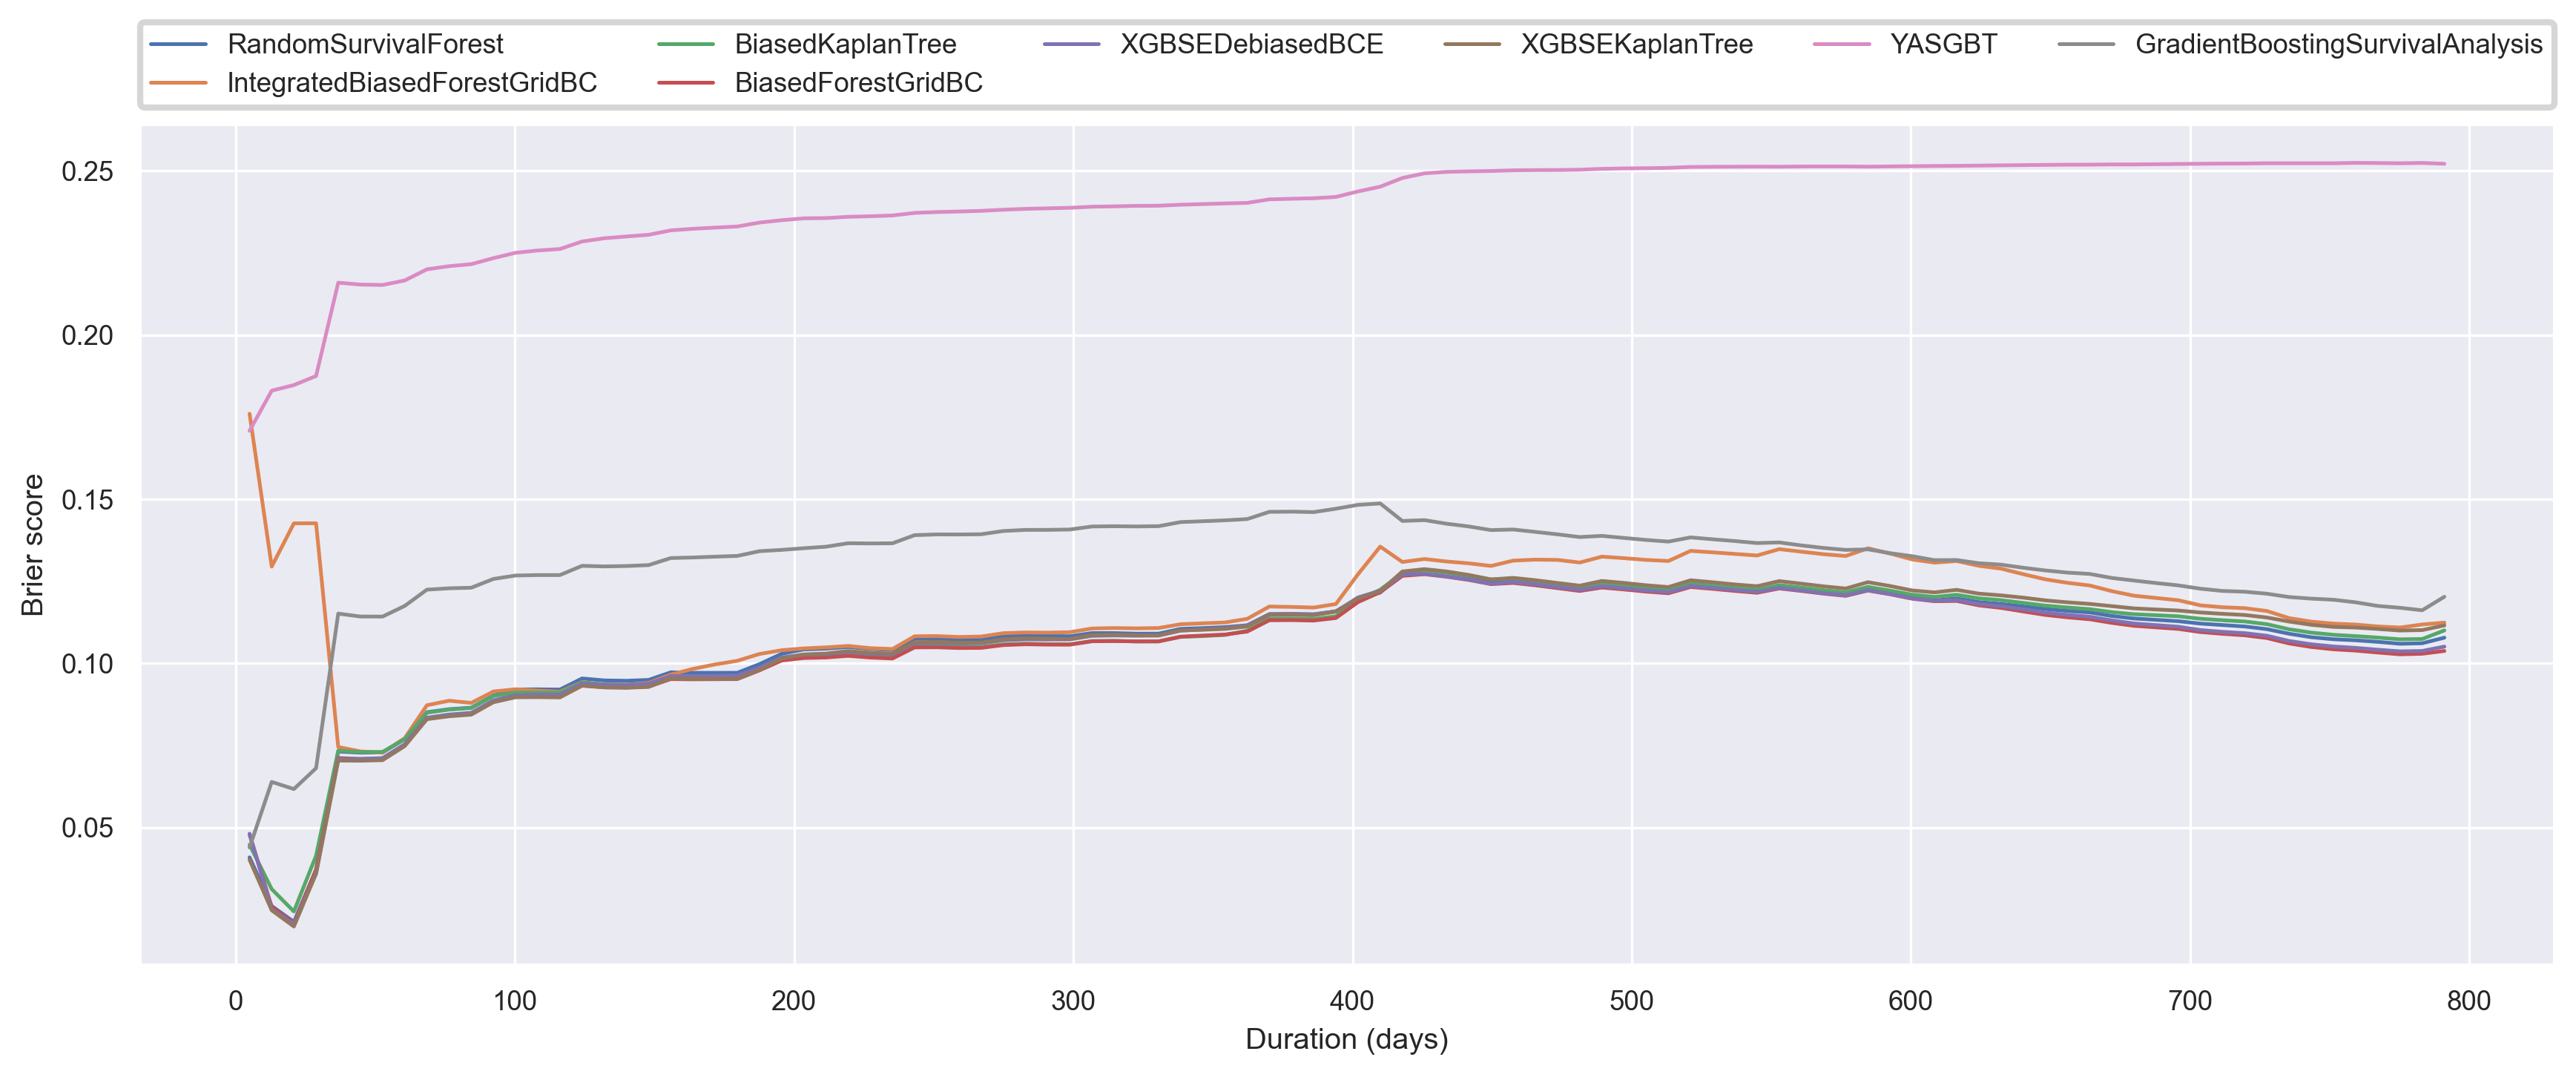

In [113]:
plot_brier_scores(df_lines)

Brier scores from the [PyCox paper](https://jmlr.org/papers/volume20/18-424/18-424.pdf) obtained the following results with the same preprocessing:

<img src="../data/kkbox_v1/pycox_paper_figure4.png" alt="pycox-table7" style="width: 900px;"/>

### Individual predictions

In [114]:
def plot_individuals_survival_curve(df_lines, y, n_indiv=5):

    df_lines.sort_values("model", inplace=True)

    fig, axes = plt.subplots(nrows=df_lines.shape[0], ncols=1, figsize=(10, 15), constrained_layout=True)

    cols = df_lines.columns
    col_to_idx = dict(zip(cols, range(len(cols))))

    # Some models has been tested on a small datasets,
    # so we need to use the first `max_indiv_id` rows to compare all models
    max_indiv_id = min([len(el) for el in df_lines["survival_probs"].values])
    idxs_indiv = np.random.uniform(high=max_indiv_id, size=n_indiv).astype(int)

    for idx, row in enumerate(df_lines.values):
        for jdx in idxs_indiv:
            times = row[col_to_idx["times"]]
            surv_probs = row[col_to_idx["survival_probs"]][jdx, :]
            axes[idx].plot(
                times,
                surv_probs
            )
            color = axes[idx].lines[-1].get_color()
            # place the dot on the curve for viz purposes
            is_event = y["event"][jdx]
            event_time = y["duration"][jdx]
            surv_prob_projected = surv_probs[
                np.argmin(
                    np.abs(times - event_time)
                )
            ]
            axes[idx].plot(
                event_time,
                surv_prob_projected,
                "^" if is_event else "o",
                color=color,
            )
        axes[idx].set_title(row[col_to_idx["model"]])

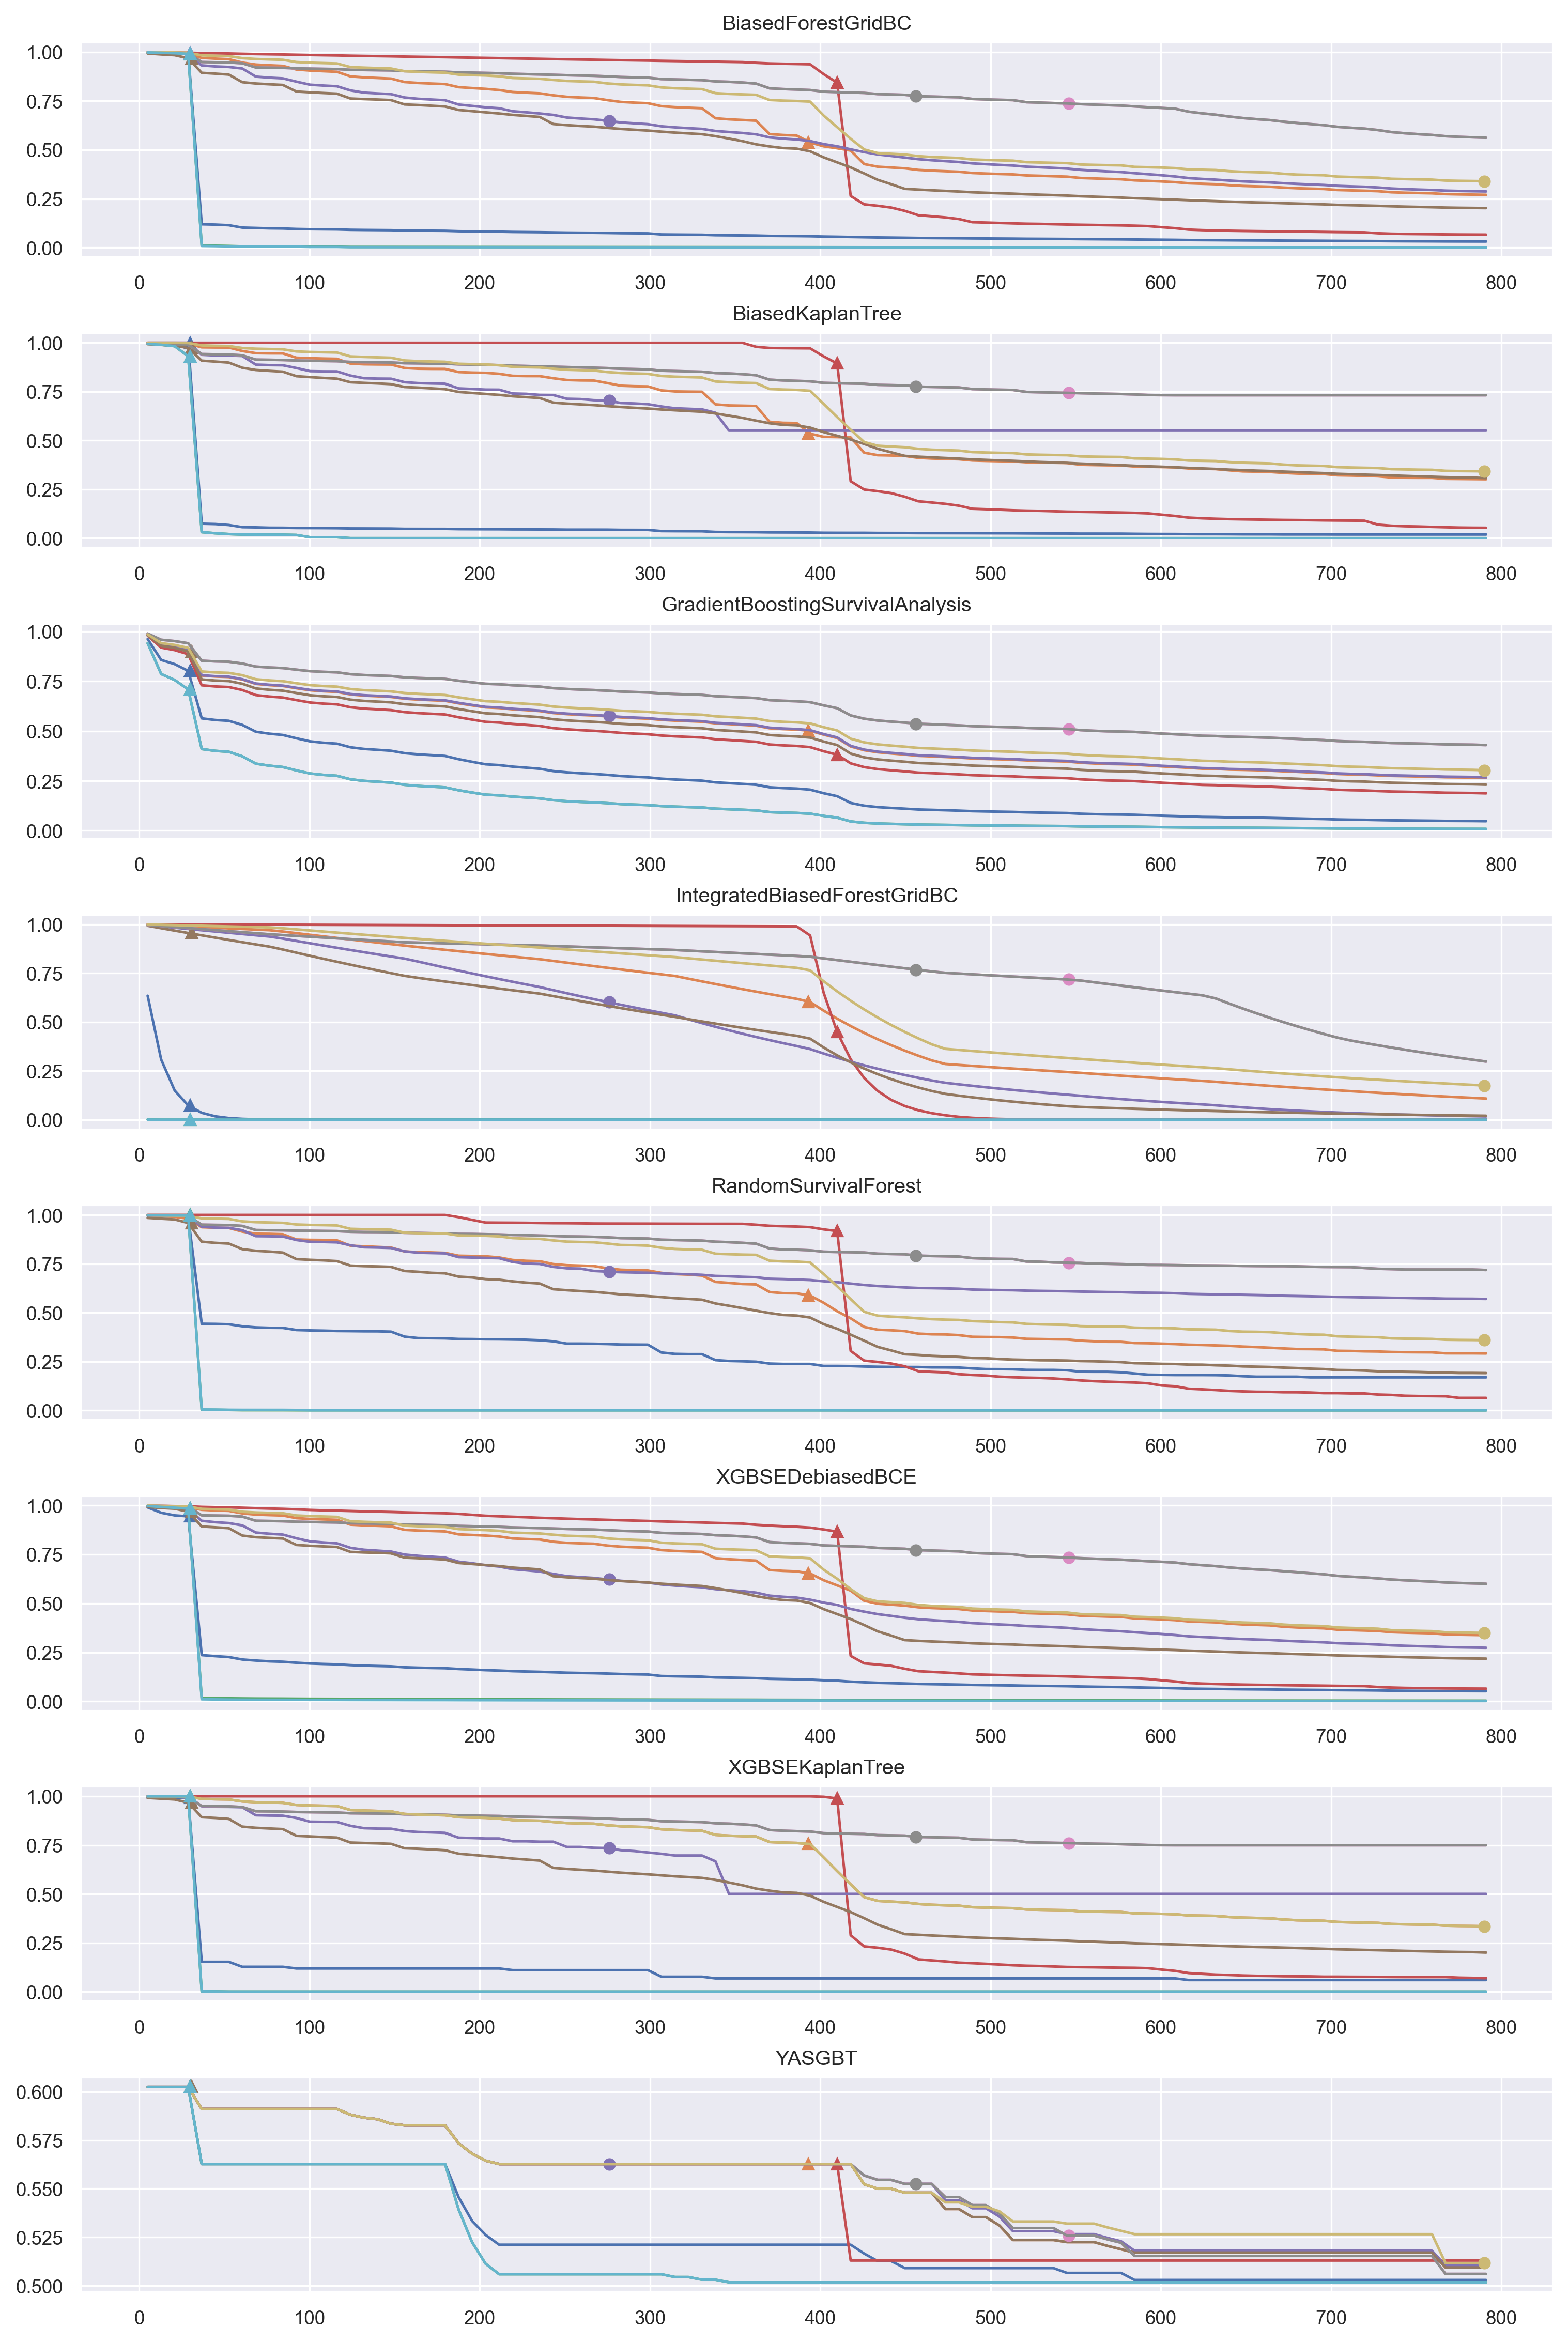

In [116]:
# "^" is an event, "o" is a survivor 
plot_individuals_survival_curve(df_lines, y, n_indiv=10)

### Kmeans on survival probs

We create clusters on our `BiasedForestGridBC` survival probs using Kmeans to try to identify user groups.

In [91]:
cols

Index(['model', 'times', 'brier_scores', 'survival_probs'], dtype='object')

In [99]:
from sklearn.cluster import KMeans

cols = df_lines.columns
col_to_idx = dict(zip(cols, range(len(cols))))

row = df_lines.values[0]
model = row[col_to_idx["model"]]
survival_probs = row[col_to_idx["survival_probs"]][:100, :]

kmeans = KMeans(n_clusters=5, init="k-means++")
labels = kmeans.fit_predict(survival_probs)
np.unique(labels)

array([0, 1, 2, 3, 4], dtype=int32)

In [100]:
kmeans.inertia_

38.27711596659991

In [106]:
kmeans.cluster_centers_.shape

(5, 100)

In [ ]:
from sklearn.cluster import KMeans
from collections import defaultdict

import seaborn as sns

cols = df_lines.columns
col_to_idx = dict(zip(cols, range(len(cols))))

all_clusters = defaultdict(list)
inertias = np.zeros((5, df_lines.shape[0]))
for idx, n_clusters in enumerate(range(3, 8)):
    for jdx, row in enumerate(df_lines.values):
        model = row[col_to_idx["Model"]]
        survival_probs = row[col_to_idx["survival_probs"]][:100, :]
        
        kmeans = KMeans(n_clusters=n_clusters, init="k-means++")
        labels = kmeans.fit_predict(survival_probs)
        clusters_centers = kmeans.cluster_centers_
        
        inertias[idx, jdx] = kmeans.inertia_
        all_clusters[model].append(clusters_centers)

sns.violinplot(x=range(3, 8), y=)

In [ ]:

#fig, ax = plt.subplots(figsize=(14, 5))
for row in df_lines.values:
    ax.plot(
        row[col_to_idx["times"]],
        row[col_to_idx["brier_scores"]],
        label=row[col_to_idx["model"]],
    )
#plt.ylim([0, .225])
plt.xlabel("Duration (days)")
plt.ylabel("Brier score")
legend = plt.legend(
    bbox_to_anchor=(0, 1.02, 1, 0.2),
    loc="lower left",
    mode="expand",
    borderaxespad=0,
    ncol=6,
    facecolor='white',
);
frame = legend.get_frame()
frame.set_linewidth(2)

In [129]:
idgbc.estimator[-1].period_

78.6